# Inference

In this notebook, we will use the trained model to generate captions for images in the test dataset.


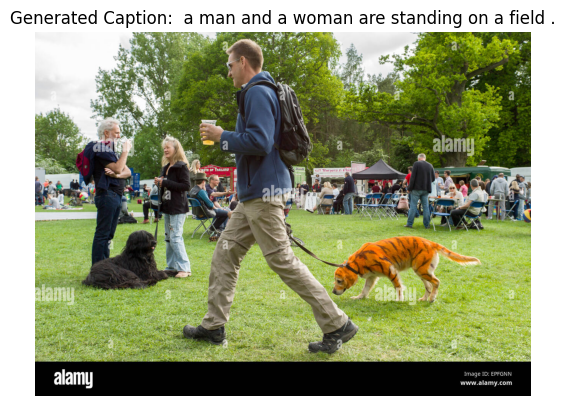

In [8]:
from PIL import Image
import torch
from torchvision import transforms
from model import EncoderCNN, DecoderRNN
from nlp_utils import clean_sentence
import os
import pickle
import matplotlib.pyplot as plt

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the necessary parameters
embed_size = 256  # Assuming it's the same as during training
hidden_size = 512  # Assuming it's the same as during training
vocab_file = "vocab.pkl"  # Assuming the name of the vocabulary file

# Load the vocabulary
with open(os.path.join("./data", vocab_file), "rb") as f:
    vocab = pickle.load(f)

vocab_size = len(vocab)

# Initialize the encoder and decoder.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Moving models to the appropriate device
encoder.to(device)
decoder.to(device)

# Load the trained weights
encoder_file = "encoder-3.pkl"  # Update with the appropriate file name
decoder_file = "decoder-3.pkl"  # Update with the appropriate file name

encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file), weights_only=True))
decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file), weights_only=True))

# Set models to evaluation mode
encoder.eval()
decoder.eval()

# Load the test image
test_image_path = "../test.jpg"  # Replace with the path to your test image
test_image = Image.open(test_image_path).convert("RGB")

# Apply transformations to the test image
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Preprocess the test image
test_image = transform_test(test_image).unsqueeze(0)  # Add batch dimension

# Move the preprocessed image to the appropriate device
test_image = test_image.to(device)

# Pass the test image through the encoder
with torch.no_grad():
    features = encoder(test_image).unsqueeze(1)

# Generate captions with the decoder
with torch.no_grad():
    output = decoder.sample(features)

# Convert the output into a clean sentence
caption = clean_sentence(output, vocab.idx2word)

# Display the test image with the generated caption
plt.imshow(Image.open(test_image_path))
plt.axis('off')
plt.title('Generated Caption: ' + caption)
plt.show()
